# Mean reverting strategy based on Bollinger bands Strategy

This notebook answers question 3.5 form the text book Advances in Financial Machine Learning.

3.5 Develop a mean-reverting strategy based on Bollinger bands. For each observation, the model suggests a side, but not a size of the bet.

* (a) Derive meta-labels for ptSl = [0, 2] and t1 where numDays = 1. Use as trgt the daily standard deviation as computed by Snippet 3.1.
* (b) Train a random forest to decide whether to trade or not. Use as features: volatility, seial correlation, and teh crossinmg moving averages.
* (c) What is teh accuracy of prediction from the primary model? (i.e. if the secondary model does not filter the bets) What are the precision, recall and FI-scores?
* (d) What is teh accuracy of prediction from the primary model? What are the precision, recall and FI-scores?


In [1]:
# Import the Hudson and Thames MlFinLab package
import mlfinlab as ml

In [2]:
import numpy as np
import pandas as pd
import pyfolio as pf
import timeit

from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline

/home/jackal08/anaconda3/envs/test_pip/lib/python3.6/site-packages/pyfolio/pos.py:28: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  ' to position notionals.'


### Read in Data
We are using the dollar bars based off of the high quality HFT data we purchased. There is a sample of bars available in this branch as well. 

In [3]:
# Read in data
data = pd.read_csv('official_data/dollar_bars.csv')
data.index = pd.to_datetime(data['date_time'])
data = data.drop('date_time', axis=1)

---
### Define helper functions

In [4]:
# Compute RSI
def relative_strength_index(df, n):
        """Calculate Relative Strength Index(RSI) for given data.
        https://github.com/Crypto-toolbox/pandas-technical-indicators/blob/master/technical_indicators.py
        
        :param df: pandas.DataFrame
        :param n: 
        :return: pandas.DataFrame
        """
        i = 0
        UpI = [0]
        DoI = [0]
        while i + 1 <= df.index[-1]:
            UpMove = df.loc[i + 1, 'high'] - df.loc[i, 'high']
            DoMove = df.loc[i, 'low'] - df.loc[i + 1, 'low']
            if UpMove > DoMove and UpMove > 0:
                UpD = UpMove
            else:
                UpD = 0
            UpI.append(UpD)
            if DoMove > UpMove and DoMove > 0:
                DoD = DoMove
            else:
                DoD = 0
            DoI.append(DoD)
            i = i + 1
        UpI = pd.Series(UpI)
        DoI = pd.Series(DoI)
        PosDI = pd.Series(UpI.ewm(span=n, min_periods=n).mean())
        NegDI = pd.Series(DoI.ewm(span=n, min_periods=n).mean())
        RSI = pd.Series(round(PosDI * 100. / (PosDI + NegDI)), name='RSI_' + str(n))
        # df = df.join(RSI)
        return RSI

def get_rsi(data, window=14):
    df = data.copy(deep=True).reset_index()
    rsi = relative_strength_index(df, window)
    rsi_df = pd.Series(data=rsi.values, index=data.index)
    return rsi_df

In [5]:
def bbands(close_prices, window, no_of_stdev):
    # rolling_mean = close_prices.rolling(window=window).mean()
    # rolling_std = close_prices.rolling(window=window).std()
    rolling_mean = close_prices.ewm(span=window).mean()
    rolling_std = close_prices.ewm(span=window).std()

    upper_band = rolling_mean + (rolling_std * no_of_stdev)
    lower_band = rolling_mean - (rolling_std * no_of_stdev)

    return rolling_mean, upper_band, lower_band

---
### Fit a Primary Model: Mean-reverting based on Bollinger bands
Based on the mean-reverting Bollinger band strategy.


In [6]:
# compute bands
window = 50
data['avg'], data['upper'], data['lower'] = bbands(data['close'], window, no_of_stdev=1.5)
data.sample(10)

,open,high,low,close,cum_vol,cum_dollar,cum_ticks,avg,upper,lower
date_time,,,,,,,,,,
2015-12-14 18:42:20.172,2000.75,2003.00,1997.00,1997.75,34996,70009302.50,4853,2001.812021,2018.207702,1985.416341
2016-08-29 08:25:44.953,2166.75,2168.50,2164.75,2166.00,32341,70059966.00,5242,2167.345340,2175.728175,2158.962505
2014-09-19 15:18:35.973,2008.25,2008.75,2007.00,2008.00,34862,70001493.50,8509,2005.388024,2014.141033,1996.635016
2012-11-26 08:44:18.011,1400.00,1402.00,1398.50,1401.00,49977,70001943.25,17390,1392.233600,1406.956662,1377.510539
2012-08-06 10:00:53.729,1388.00,1392.25,1387.25,1391.50,50357,70011252.50,17824,1380.869496,1397.779918,1363.959073
2013-05-15 14:14:46.821,1647.50,1648.00,1646.00,1646.25,42519,70032737.25,9276,1643.182281,1652.023239,1634.341324
2012-11-23 15:35:45.997,1401.00,1402.25,1400.75,1400.75,49972,70031433.25,11601,1387.832101,1400.390427,1375.273774
2014-03-07 16:55:01.597,1874.00,1876.00,1873.50,1873.50,37346,70020386.75,10809,1876.440819,1882.934840,1869.946798
2011-08-16 17:32:22.426,1181.75,1184.75,1180.00,1184.25,59326,70150933.00,18625,1189.130622,1200.548842,1177.712403


In [7]:
# Compute RSI
rsi_df = get_rsi(data, window=14)
data['rsi'] = pd.Series(data=rsi_df.values, index=data.index)

# Drop the NaN values from our data set
data.dropna(axis=0, how='any', inplace=True)

---
### Fit a Primary Model: Bollinger Band Mean-Reversion

In [8]:
# Compute sides
data['side'] = np.nan 

long_signals = (data['close'] <= data['lower']) 
short_signals = (data['close'] >= data['upper']) 

data.loc[long_signals, 'side'] = 1
data.loc[short_signals, 'side'] = -1

print(data.side.value_counts())

# Remove Look ahead biase by lagging the signal
data['side'] = data['side'].shift(1)

 1.0    4242
-1.0    3989
Name: side, dtype: int64


In [9]:
# Save the raw data
raw_data = data.copy()

# Drop the NaN values from our data set
data.dropna(axis=0, how='any', inplace=True)

In [10]:
print(data.side.value_counts())

 1.0    4242
-1.0    3989
Name: side, dtype: int64


### Filter Events: CUSUM Filter
Predict what will happen when a CUSUM event is triggered. Use the signal from the MAvg Strategy to determine the side of the bet.

In [11]:
# Compute daily volatility
daily_vol = ml.util.get_daily_vol(close=data['close'], lookback=50)

# Apply Symmetric CUSUM Filter and get timestamps for events
# Note: Only the CUSUM filter needs a point estimate for volatility
cusum_events = ml.filters.cusum_filter(data['close'], threshold=daily_vol['2011-09-01':'2018-01-01'].mean() * 0.1)

# Compute vertical barrier
vertical_barriers = ml.labeling.add_vertical_barrier(t_events=cusum_events, close=data['close'], num_days=1)

In [12]:
pt_sl = [0, 2]
min_ret = 0.0005
triple_barrier_events = ml.labeling.get_events(close=data['close'],
                                               t_events=cusum_events,
                                               pt_sl=pt_sl,
                                               target=daily_vol,
                                               min_ret=min_ret,
                                               num_threads=2,
                                               vertical_barrier_times=vertical_barriers,
                                               side_prediction=data['side'])

/home/jackal08/anaconda3/envs/test_pip/lib/python3.6/site-packages/mlfinlab/labeling/labeling.py:117: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  target = target.loc[t_events]
2019-04-18 16:32:37.463475 100.0% apply_pt_sl_on_t1 done after 0.09 minutes. Remaining 0.0 minutes.


In [13]:
labels = ml.labeling.get_bins(triple_barrier_events, data['close'])
labels.side.value_counts()

 1.0    2558
-1.0    2084
Name: side, dtype: int64

---
### Results of Primary Model:


In [14]:
primary_forecast = pd.DataFrame(labels['bin'])
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

# Performance Metrics
actual = primary_forecast['actual']
pred = primary_forecast['pred']
print(classification_report(y_true=actual, y_pred=pred))

print("Confusion Matrix")
print(confusion_matrix(actual, pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3785
           1       0.18      1.00      0.31       857

   micro avg       0.18      0.18      0.18      4642
   macro avg       0.09      0.50      0.16      4642
weighted avg       0.03      0.18      0.06      4642

Confusion Matrix
[[   0 3785]
 [   0  857]]

Accuracy
0.1846186988367083


/home/jackal08/anaconda3/envs/test_pip/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


**A few takeaways**
* There is an imbalance in the classes - far more are classified as "no trade"
* Meta-labeling says that there are many false-positives  
* the sklearn's confusion matrix is [[TN, FP][FN, TP]] 

---
## Fit a Meta Model
Train a random forest to decide whether to trade or not (i.e 1 or 0 respectively) since the earlier model has decided the side (-1 or 1)

Create the following features: 
* Volatility
* Serial Correlation
* The returns at the different lags from the serial correlation
* The sides from the SMavg Strategy

In [15]:
raw_data.head()

,open,high,low,close,cum_vol,cum_dollar,cum_ticks,avg,upper,lower,rsi,side
date_time,,,,,,,,,,,,
2011-08-01 13:56:56.220,1293.25,1294.00,1292.00,1292.25,54159,70025279.50,12010,1300.315764,1307.910651,1292.720876,13.0,NaN
2011-08-01 14:00:21.448,1292.25,1292.75,1286.75,1286.75,54266,70000564.25,10157,1299.136791,1308.500955,1289.772626,9.0,1.0
2011-08-01 14:01:38.747,1286.75,1287.00,1284.00,1284.50,54475,70034099.00,8778,1297.922642,1308.843635,1287.001649,7.0,1.0
2011-08-01 14:03:22.782,1284.50,1285.00,1278.75,1279.00,54589,70000494.25,10823,1296.418749,1309.539297,1283.298202,5.0,1.0
2011-08-01 14:04:31.604,1279.00,1281.50,1276.00,1276.00,55049,70397187.25,10651,1294.858757,1309.982621,1279.734893,5.0,1.0


### Features

In [16]:
# Log Returns
raw_data['log_ret'] = np.log(raw_data['close']).diff()

# Momentum
raw_data['mom1'] = raw_data['close'].pct_change(periods=1)
raw_data['mom2'] = raw_data['close'].pct_change(periods=2)
raw_data['mom3'] = raw_data['close'].pct_change(periods=3)
raw_data['mom4'] = raw_data['close'].pct_change(periods=4)
raw_data['mom5'] = raw_data['close'].pct_change(periods=5)

# Volatility
window_stdev = 50
raw_data['volatility'] = raw_data['log_ret'].rolling(window=window_stdev, min_periods=window_stdev, center=False).std()

# Serial Correlation (Takes about 4 minutes)
window_autocorr = 50

raw_data['autocorr_1'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=1), raw=False)
raw_data['autocorr_2'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=2), raw=False)
raw_data['autocorr_3'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=3), raw=False)
raw_data['autocorr_4'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=4), raw=False)
raw_data['autocorr_5'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=5), raw=False)

# Get the various log -t returns
raw_data['log_t1'] = raw_data['log_ret'].shift(1)
raw_data['log_t2'] = raw_data['log_ret'].shift(2)
raw_data['log_t3'] = raw_data['log_ret'].shift(3)
raw_data['log_t4'] = raw_data['log_ret'].shift(4)
raw_data['log_t5'] = raw_data['log_ret'].shift(5)

# Add fast and slow moving averages
fast_window = 7
slow_window = 15

raw_data['fast_mavg'] = raw_data['close'].rolling(window=fast_window, min_periods=fast_window, center=False).mean()
raw_data['slow_mavg'] = raw_data['close'].rolling(window=slow_window, min_periods=slow_window, center=False).mean()


In [17]:
# Add Trending signals
raw_data['sma'] = np.nan

long_signals = raw_data['fast_mavg'] >= raw_data['slow_mavg']
short_signals = raw_data['fast_mavg'] < raw_data['slow_mavg']
raw_data.loc[long_signals, 'sma'] = 1
raw_data.loc[short_signals, 'sma'] = -1

In [18]:
# Re compute sides
raw_data['side'] = np.nan

long_signals = raw_data['close'] <= raw_data['lower'] 
short_signals = raw_data['close'] >= raw_data['upper'] 

raw_data.loc[long_signals, 'side'] = 1
raw_data.loc[short_signals, 'side'] = -1

In [19]:
# Remove look ahead bias
raw_data = raw_data.shift(1)

#### Now get the data at the specified events

In [20]:
# Get features at event dates
X = raw_data.loc[labels.index, :]

# Drop unwanted columns
X.drop(['avg', 'upper', 'lower', 'open', 'high', 'low', 'close', 'cum_vol', 'cum_dollar', 'cum_ticks','fast_mavg', 'slow_mavg',], axis=1, inplace=True)

y = labels['bin']
X.head()

,rsi,side,log_ret,mom1,mom2,mom3,mom4,mom5,volatility,autocorr_1,autocorr_2,autocorr_3,autocorr_4,autocorr_5,log_t1,log_t2,log_t3,log_t4,log_t5,sma
2011-08-02 17:02:16.995,16.0,1.0,-0.000990,-0.000990,-0.004339,-0.005516,-0.006299,-0.004732,0.001709,-0.024846,0.030397,-0.055224,0.226567,0.122310,-0.003359,-0.001183,-0.000788,0.001576,-0.000591,-1.0
2011-08-02 18:06:11.084,19.0,1.0,-0.002381,-0.002379,-0.002971,-0.005533,-0.005925,-0.005336,0.001762,-0.012131,0.013186,-0.193096,0.241242,0.083327,-0.000594,-0.002572,-0.000395,0.000593,0.002374,-1.0
2011-08-02 19:45:56.176,25.0,1.0,-0.002390,-0.002387,-0.002387,-0.003180,-0.005355,-0.007717,0.001723,0.026686,-0.181886,-0.124395,0.193267,-0.017387,0.000000,-0.000795,-0.002184,-0.002377,0.001188,-1.0
2011-08-03 14:37:04.871,24.0,1.0,-0.002624,-0.002620,-0.004627,-0.003424,-0.006625,-0.009013,0.001713,0.034175,-0.134653,-0.011515,-0.083964,-0.118366,-0.002014,0.001208,-0.003217,-0.002406,-0.001601,-1.0
2011-08-03 14:44:34.209,17.0,1.0,0.000000,0.000000,-0.001014,-0.004244,-0.006853,-0.008851,0.001704,0.072997,-0.083414,-0.002388,-0.028741,-0.036896,-0.001014,-0.003239,-0.002624,-0.002014,0.001208,-1.0


### Fit a model

In [21]:
# Split data into training, validation and test sets
X_training_validation = X['2011-09-01':'2018-01-01']
y_training_validation = y['2011-09-01':'2018-01-01']
X_train, X_validate, y_train, y_validate = train_test_split(X_training_validation, y_training_validation, test_size=0.2, shuffle=False)

In [22]:
train_df = pd.concat([y_train, X_train], axis=1, join='inner')
train_df['bin'].value_counts()

0    2385
1     531
Name: bin, dtype: int64

In [23]:
# Upsample the training data to have a 50 - 50 split
# https://elitedatascience.com/imbalanced-classes
majority = train_df[train_df['bin'] == 0]
minority = train_df[train_df['bin'] == 1]

new_minority = resample(minority, 
                   replace=True,     # sample with replacement
                   n_samples=majority.shape[0],    # to match majority class
                   random_state=42)

train_df = pd.concat([majority, new_minority])
train_df = shuffle(train_df, random_state=42)

train_df['bin'].value_counts()

1    2385
0    2385
Name: bin, dtype: int64

In [24]:
# Create training data
y_train = train_df['bin']
X_train= train_df.loc[:, train_df.columns != 'bin']

In [25]:
parameters = {'max_depth':[2, 3, 4, 5, 7],
              'n_estimators':[1, 10, 25, 50, 100, 256, 512],
              'random_state':[42]}
    
def perform_grid_search(X_data, y_data):
    rf = RandomForestClassifier(criterion='entropy')
    
    clf = GridSearchCV(rf, parameters, cv=4, scoring='roc_auc', n_jobs=3)
    
    clf.fit(X_data, y_data)
    
    print(clf.cv_results_['mean_test_score'])
    
    return clf.best_params_['n_estimators'], clf.best_params_['max_depth']

In [26]:
# extract parameters
n_estimator, depth = perform_grid_search(X_train, y_train)
c_random_state = 42
print(n_estimator, depth, c_random_state)

[0.55094958 0.63444028 0.64269547 0.64590126 0.65243522 0.6551371
 0.65437732 0.57758233 0.67091872 0.68938581 0.69095754 0.69786364
 0.70214677 0.70178009 0.59146097 0.70411721 0.73210807 0.74049967
 0.74964398 0.7546167  0.75565736 0.6235073  0.75783106 0.78250248
 0.7928879  0.80364894 0.80846502 0.81013727 0.6852779  0.84851194
 0.87912388 0.88530658 0.89584192 0.89990841 0.90331725]
512 7 42


In [27]:
# Random Forest Model
rf = RandomForestClassifier(max_depth=depth, n_estimators=n_estimator,
                            criterion='entropy', random_state=c_random_state)
rf.fit(X_train, y_train.values.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=512, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

#### Training Metrics

              precision    recall  f1-score   support

           0       0.93      0.79      0.86      2385
           1       0.82      0.94      0.88      2385

   micro avg       0.87      0.87      0.87      4770
   macro avg       0.88      0.87      0.87      4770
weighted avg       0.88      0.87      0.87      4770

Confusion Matrix
[[1893  492]
 [ 137 2248]]

Accuracy
0.8681341719077568


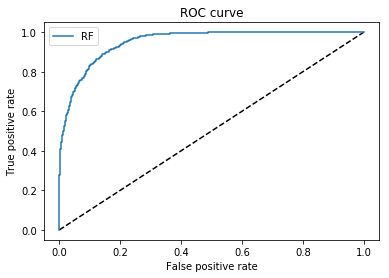

In [28]:
# Performance Metrics
y_pred_rf = rf.predict_proba(X_train)[:, 1]
y_pred = rf.predict(X_train)
fpr_rf, tpr_rf, _ = roc_curve(y_train, y_pred_rf)
print(classification_report(y_train, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_train, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_train, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

#### Validation Metrics

              precision    recall  f1-score   support

           0       0.81      0.93      0.87       578
           1       0.39      0.16      0.23       151

   micro avg       0.77      0.77      0.77       729
   macro avg       0.60      0.55      0.55       729
weighted avg       0.72      0.77      0.73       729

Confusion Matrix
[[540  38]
 [127  24]]

Accuracy
0.7736625514403292


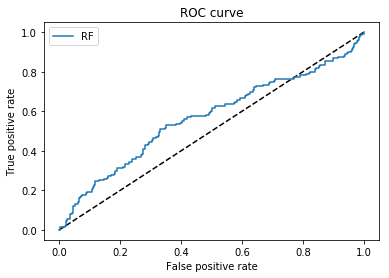

In [29]:
# Meta-label
# Performance Metrics
y_pred_rf = rf.predict_proba(X_validate)[:, 1]
y_pred = rf.predict(X_validate)
fpr_rf, tpr_rf, _ = roc_curve(y_validate, y_pred_rf)
print(classification_report(y_validate, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_validate, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_validate, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [30]:
# Primary model
primary_forecast = pd.DataFrame(labels['bin'])
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

start = primary_forecast.index.get_loc('2016-08-01 10:31:44.455000')
end = primary_forecast.index.get_loc('2017-12-29 21:03:37.018000') + 1

subset_prim = primary_forecast[start:end]

# Performance Metrics
actual = subset_prim['actual']
pred = subset_prim['pred']
print(classification_report(y_true=actual, y_pred=pred))

print("Confusion Matrix")
print(confusion_matrix(actual, pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       578
           1       0.21      1.00      0.34       151

   micro avg       0.21      0.21      0.21       729
   macro avg       0.10      0.50      0.17       729
weighted avg       0.04      0.21      0.07       729

Confusion Matrix
[[  0 578]
 [  0 151]]

Accuracy
0.20713305898491083


/home/jackal08/anaconda3/envs/test_pip/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


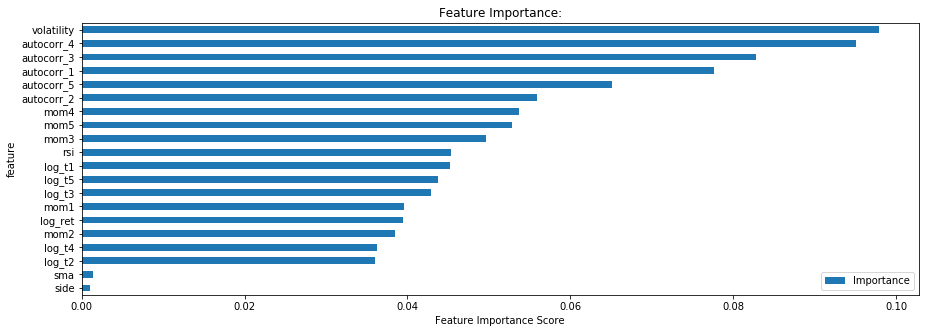

In [31]:
# Feature Importance
title = 'Feature Importance:'
figsize = (15, 5)

feat_imp = pd.DataFrame({'Importance':rf.feature_importances_})    
feat_imp['feature'] = X.columns
feat_imp.sort_values(by='Importance', ascending=False, inplace=True)
feat_imp = feat_imp

feat_imp.sort_values(by='Importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp.plot.barh(title=title, figsize=figsize)
plt.xlabel('Feature Importance Score')
plt.show()

Note how low the side is ranked.

---
## Performance Tear Sheets (In-sample)

In [32]:
# Set-up the function to extract the KPIs from pyfolio
perf_func = pf.timeseries.perf_stats

In [33]:
def get_daily_returns(intraday_returns):
    """
    This changes returns into daily returns that will work using pyfolio. Its not perfect...
    """
    
    cum_rets = ((intraday_returns + 1).cumprod())

    # Downsample to daily
    daily_rets = cum_rets.resample('B').last()

    # Forward fill, Percent Change, Drop NaN
    daily_rets = daily_rets.ffill().pct_change().dropna()
    
    return daily_rets

In [34]:
test_dates = X_validate.index

base_rets = labels.loc[test_dates, 'ret']
primary_model_rets = get_daily_returns(base_rets)

# Save the statistics in a dataframe
perf_stats_all = perf_func(returns=primary_model_rets, 
                           factor_returns=None, 
                           positions=None,
                           transactions=None,
                           turnover_denom="AGB")
perf_stats_df = pd.DataFrame(data=perf_stats_all, columns=['Primary Model'])

# pf.create_returns_tear_sheet(labels.loc[test_dates, 'ret'], benchmark_rets=None)
pf.show_perf_stats(primary_model_rets)

Start date,2016-08-02
End date,2017-12-29
Total months,17
,Backtest
Annual return,146.9%
Cumulative returns,275.5%
Annual volatility,67.2%
Sharpe ratio,1.59
Calmar ratio,10.06
Stability,0.86
Max drawdown,-14.6%


In [35]:
meta_returns = labels.loc[test_dates, 'ret'] * y_pred
daily_meta_rets = get_daily_returns(meta_returns)

# save the KPIs in a dataframe
perf_stats_all = perf_func(returns=daily_meta_rets, 
                           factor_returns=None, 
                           positions=None,
                           transactions=None,
                           turnover_denom="AGB")

perf_stats_df['Meta Model'] = perf_stats_all

# pf.create_returns_tear_sheet(meta_returns, benchmark_rets=None)
pf.show_perf_stats(daily_meta_rets)

/home/jackal08/anaconda3/envs/test_pip/lib/python3.6/site-packages/empyrical/stats.py:1511: RuntimeWarning: divide by zero encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Start date,2016-08-02
End date,2017-12-29
Total months,17
,Backtest
Annual return,27.2%
Cumulative returns,42.3%
Annual volatility,11.8%
Sharpe ratio,2.09
Calmar ratio,12.29
Stability,0.88
Max drawdown,-2.2%


---
## Perform out-of-sample test

In [36]:
# extarct data for out-of-sample (OOS)
X_oos = X['2018-01-02':]
y_oos = y['2018-01-02':]

              precision    recall  f1-score   support

           0       0.85      0.68      0.75       749
           1       0.20      0.41      0.27       151

   micro avg       0.63      0.63      0.63       900
   macro avg       0.53      0.54      0.51       900
weighted avg       0.74      0.63      0.67       900

Confusion Matrix
[[506 243]
 [ 89  62]]

Accuracy
0.6311111111111111


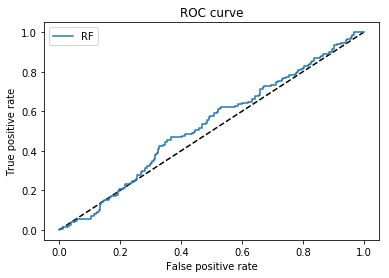

In [37]:
# Performance Metrics
y_pred_rf = rf.predict_proba(X_oos)[:, 1]
y_pred = rf.predict(X_oos)
fpr_rf, tpr_rf, _ = roc_curve(y_oos, y_pred_rf)
print(classification_report(y_oos, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_oos, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_oos, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [38]:
# Primary model
primary_forecast = pd.DataFrame(labels['bin'])
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

subset_prim = primary_forecast['2018-01-02':]

# Performance Metrics
actual = subset_prim['actual']
pred = subset_prim['pred']
print(classification_report(y_true=actual, y_pred=pred))

print("Confusion Matrix")
print(confusion_matrix(actual, pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       749
           1       0.17      1.00      0.29       151

   micro avg       0.17      0.17      0.17       900
   macro avg       0.08      0.50      0.14       900
weighted avg       0.03      0.17      0.05       900

Confusion Matrix
[[  0 749]
 [  0 151]]

Accuracy
0.16777777777777778


/home/jackal08/anaconda3/envs/test_pip/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
## Performance Tear Sheets (Out-of-sample)

In [39]:
test_dates = X_oos.index

base_rets_oos = labels.loc[test_dates, 'ret']
primary_model_rets_oos = get_daily_returns(base_rets_oos)

# Save the statistics in a dataframe
perf_stats_all = perf_func(returns=primary_model_rets_oos, 
                           factor_returns=None, 
                           positions=None,
                           transactions=None,
                           turnover_denom="AGB")

perf_stats_df['Primary Model OOS'] = perf_stats_all


# pf.create_returns_tear_sheet(labels.loc[test_dates, 'ret'], benchmark_rets=None)
pf.show_perf_stats(primary_model_rets_oos)

Start date,2018-01-04
End date,2019-01-28
Total months,13
,Backtest
Annual return,17.7%
Cumulative returns,19.7%
Annual volatility,95.0%
Sharpe ratio,0.65
Calmar ratio,0.29
Stability,0.16
Max drawdown,-61.9%


Start date,2018-01-04
End date,2019-01-28
Total months,13
,Backtest
Annual return,35.3%
Cumulative returns,39.6%
Annual volatility,56.7%
Sharpe ratio,0.82
Calmar ratio,0.96
Stability,0.63
Max drawdown,-36.8%


/home/jackal08/anaconda3/envs/test_pip/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,36.78,2018-11-09,2018-12-19,NaT,NaN
1,33.98,2018-01-29,2018-02-05,2018-05-08,72
2,6.94,2018-10-09,2018-10-10,2018-10-11,3
3,6.87,2018-10-17,2018-10-24,2018-10-29,9
4,3.11,2018-06-22,2018-06-25,2018-06-27,4


/home/jackal08/anaconda3/envs/test_pip/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


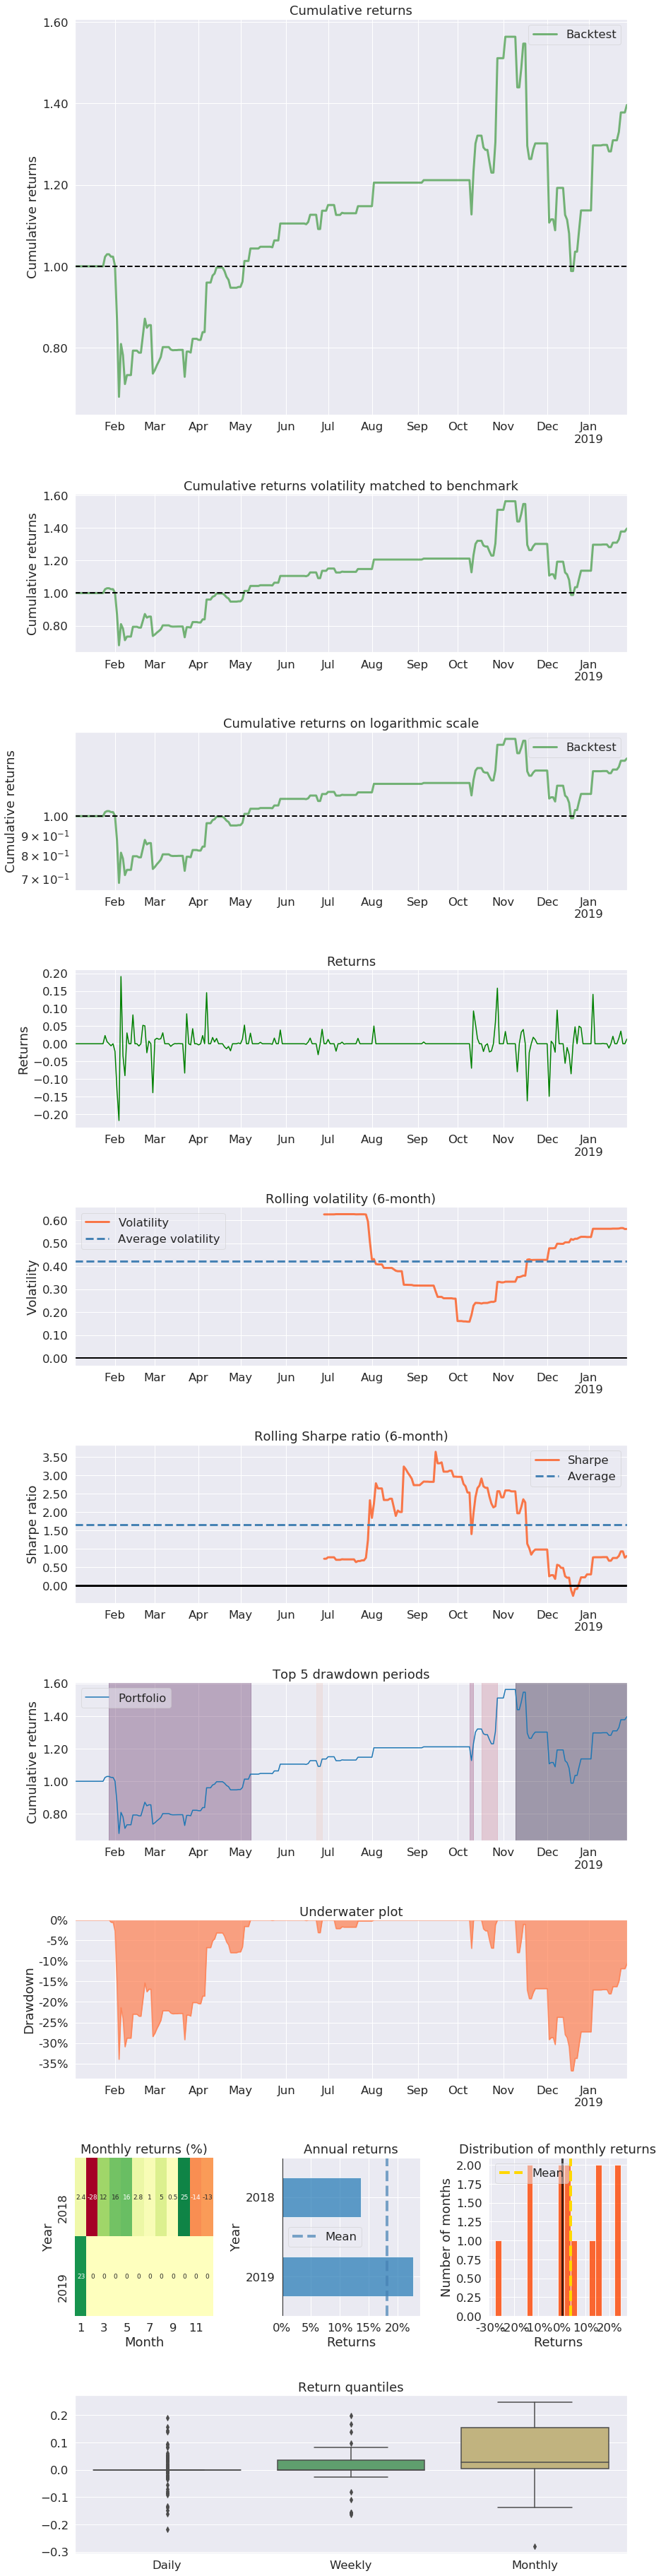

In [40]:
meta_returns = labels.loc[test_dates, 'ret'] * y_pred
daily_rets_meta = get_daily_returns(meta_returns)

# save the KPIs in a dataframe
perf_stats_all = perf_func(returns=daily_rets_meta, 
                           factor_returns=None, 
                           positions=None,
                           transactions=None,
                           turnover_denom="AGB")

perf_stats_df['Meta Model OOS'] = perf_stats_all

pf.create_returns_tear_sheet(daily_rets_meta, benchmark_rets=None)

---
## Conclusion
There are a few takeaways from the Bollinger bands mean-reverting strategy:
1. In out-of-sample tests, the meta-model out-performs the primary model in all key statistics:
    * Annualized returns: 17.7% vs. 35.3%
    * Annualized volatility: 95% vs. 40%
    * Sharpe ratio: 0.65 vs. 0.82 
2. In all cases the meta-model (one with meta-labeling) decreases annualized volatility, maximum drawdown and increases Sharpe ratio compared to the primary model     
